In the [previous notebook](AmazonForest-model-train-V1.ipynb) we built the first version of our CNN model to recognize and classify satellite images of the Amazon Forest.<BR>
The core model architecture comprised of 3 blocks, each block made of 2 CNN layers followed by a MaxPool layer, and a Dropout layer.<BR>
On training the model we observed the model tend to overfit the training dataset and did not generalize well to the holdout validation dataset.<BR>

In this notebook we use the technique of image augmentation to artificially expand the training dataset. Image augmentation introduces variations in the dataset, exposing the model to new perspectives, new geometric transformations, thus enabling the model to generalize better.<BR>
    
The model is trained on a 8vCPUs x 32GB RAM virtual machine; the system does not have any GPUs.

#### Lets first load the required libraries¶

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from tqdm.keras import TqdmCallback
from utils import data_utils, model_utils, plot_utils
import matplotlib.pyplot as plt
%matplotlib inline

#### Configure the number of CPU threads to be used by independent non-blocking operations:¶

In [2]:
num_threads = 8
tf.config.threading.set_inter_op_parallelism_threads(num_threads)

#### Load the csv containing the target labels to a pandas dataframe¶

In [3]:
!ls data/train_labels.csv

data/train_labels.csv


In [4]:
df_target = pd.read_csv('data/train_labels.csv')
df_target.head()

,image_name,tags,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,train_0,haze primary,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,train_1,agriculture clear primary water,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,train_2,clear primary,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,train_3,clear primary,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,train_4,agriculture clear habitation primary road,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0


In [5]:
categories = list(df_target.select_dtypes(include='int64').columns)

In [6]:
categories

['agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water']

The dataset has 17 distinct class labels.<BR>
For a description of these labels please see the [data pre-processing notebook](./AmazonForest-data-process.ipynb) 

#### Load the data saved in the npz files during the pre-processing step
* Load the individual npz files,
* Retrieve the data from these,
* Stack the data to create the numpy arrays corresponding to all the images and the labels.

In [7]:
%%time
file_path = 'data/amazon_forest_part*npz'
X, Y = data_utils.load_data(file_path)

CPU times: user 13.2 s, sys: 1.1 s, total: 14.3 s
Wall time: 20.5 s


In [8]:
X.shape

(40479, 128, 128, 3)

In [9]:
Y.shape

(40479, 17)

#### Split the data into train and test data sets

In [10]:
%%time

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

CPU times: user 251 ms, sys: 301 ms, total: 552 ms
Wall time: 552 ms


#### Resacle the data from [0,255] --> [0,1]
* Normalize the data so that each pixel in the X_train and X_test arrays is scaled to a value between [0,1]

In [11]:
%%time

X_train = data_utils.rescale_data(X_train)
X_test = data_utils.rescale_data(X_test)

CPU times: user 1.35 s, sys: 1.21 s, total: 2.56 s
Wall time: 2.56 s


In [12]:
X_train.shape, X_test.shape

((32383, 128, 128, 3), (8096, 128, 128, 3))

In [13]:
Y_train.shape, Y_test.shape

((32383, 17), (8096, 17))

Now that we have created the train and test datasets, lets delete the original X and Y arrays to free up some memory

In [14]:
del X; del Y

#### Split the train dataset into train and validation sets
* We will use 20% of the training dataset as validation data during the model training phase

In [15]:
tr_size = X_train.shape[0] - int(0.2 * X_train.shape[0])

In [16]:
(X_train, X_valid) = X_train[:tr_size], X_train[tr_size:]
(Y_train, Y_valid) = Y_train[:tr_size], Y_train[tr_size:]

In [17]:
X_train.shape, X_valid.shape

((25907, 128, 128, 3), (6476, 128, 128, 3))

In [18]:
Y_train.shape, Y_valid.shape

((25907, 17), (6476, 17))

#### Create and configure the augmented image generator
* We use the ImageDataGenerator from the keras image pre-processing API to augment the training dataset.
* The ImageDataGenerator is configured to perform geometric transformations on the images such as:
  * horizontal and vertical shifts
  * horizontal and vertical flips
  * image rotations

In [19]:
datagen_train = ImageDataGenerator(
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True,  
    vertical_flip=True, 
    rotation_range = 45) 

#### Visualize original and augmented images

In [20]:
def visualize_images(x_data, title):
    '''
    INPUT:
    x_data (numpy.array) : numpy array containing a subset of images
    title (str) : title for the image plot
    
    OUTPUT:
    
    Description:
    The function uses matplotlib library to visualize a subset of original 
    images and augmented images .
    '''
    fig = plt.figure(figsize=(20,2))
    for i in range(len(x_data)):
        ax = fig.add_subplot(1, 12, i+1)
        ax.axis('off')
        ax.imshow(np.squeeze(x_data[i]))
    fig.suptitle(title, fontsize=20)
    plt.axis('off')
    plt.show()

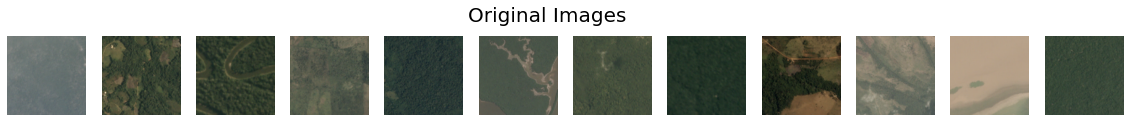

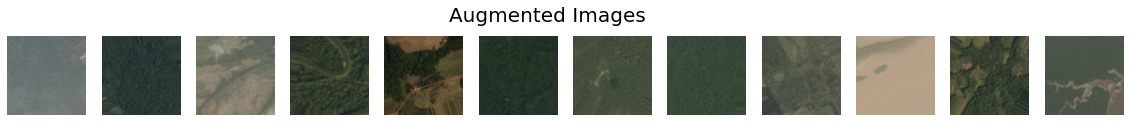

In [21]:
# take subset of training data
x_train_subset = X_train[:12]

# visualize the original images
title = 'Original Images'
visualize_images(x_train_subset, title)

# visualize augmented images
title = 'Augmented Images'
for x_batch in datagen_train.flow(x_train_subset, batch_size=12):
    visualize_images(x_batch, title)
    break;

#### Define a metric for measuring the model performance
* As seen during the [pre-processing stage](./AmazonForest-data-process.ipynb) the dataset is a multi-labeled and highly imbalanced dataset with some class labels occurring more frequently than others.
* Given the imbalanced nature of the data, classification accuracy could be a misleading metric when evaluating the model performance.
* Instead, we will use the F1-score as the metric to measure the model performance.
* The F1-score considers both precision and recall, to get a high F1-score both false positives and false negatives should be low. 

We have defined the precision(), recall(), fbeta_score() functions in the model_utils module.<BR><BR>
During the training phase, the fbeta_score function is invoked with beta=1 to compute the F1-score during each training epoch.

#### Create and compile the model
* We use the same model architecture as used in the first version. The details of the model architecture are defined in the [notebook](AmazonForest-model-eval-comments.ipynb)

In [22]:
%%time

input_shape = (128, 128, 3)
output_shape = 17

#create the model
model = model_utils.create_model(input_shape, output_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                        

2022-06-01 06:59:52.276317: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Train the model using the augmented image generator
* The model.fit() method is used to train the model.
* The data is divided into batches of batch_size=64, the total number of training epochs is set to 200.
* The model.fit() invokes the flow method of the ImageDataGenerator object, to generate augmented images in batches.
* At the end of each epoch the validation dataset is evaluated to compute the validation loss, and the best model thus far is saved to the file system.

In [23]:
%%time

batch_size = 64
epochs = 200
best_model = 'amzn_forest_imgaug.best.hdf5'

checkpointer = ModelCheckpoint(filepath=best_model, verbose=1, 
                               save_best_only=True)
    
earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
    
hist = model.fit(datagen_train.flow(X_train, Y_train, batch_size=batch_size),
                    epochs=epochs, verbose=2, callbacks=[checkpointer, TqdmCallback(verbose=2), earlystop],
                    validation_data=(X_valid, Y_valid),
                    )

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.24569, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 582s - loss: 0.2680 - fbeta_score: 0.6589 - val_loss: 0.2457 - val_fbeta_score: 0.6650 - 582s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 2/200

Epoch 2: val_loss improved from 0.24569 to 0.22929, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 580s - loss: 0.2268 - fbeta_score: 0.6723 - val_loss: 0.2293 - val_fbeta_score: 0.6905 - 580s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 3/200

Epoch 3: val_loss improved from 0.22929 to 0.21978, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 578s - loss: 0.2208 - fbeta_score: 0.6876 - val_loss: 0.2198 - val_fbeta_score: 0.6937 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 4/200

Epoch 4: val_loss did not improve from 0.21978
405/405 - 577s - loss: 0.2143 - fbeta_score: 0.7039 - val_loss: 0.2226 - val_fbeta_score: 0.7305 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 5/200

Epoch 5: val_loss improved from 0.21978 to 0.20191, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 577s - loss: 0.2055 - fbeta_score: 0.7295 - val_loss: 0.2019 - val_fbeta_score: 0.7319 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 6/200

Epoch 6: val_loss improved from 0.20191 to 0.19584, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 575s - loss: 0.1983 - fbeta_score: 0.7411 - val_loss: 0.1958 - val_fbeta_score: 0.7579 - 575s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 7/200

Epoch 7: val_loss improved from 0.19584 to 0.19245, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 578s - loss: 0.1918 - fbeta_score: 0.7522 - val_loss: 0.1924 - val_fbeta_score: 0.7689 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 8/200

Epoch 8: val_loss improved from 0.19245 to 0.19206, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 578s - loss: 0.1865 - fbeta_score: 0.7597 - val_loss: 0.1921 - val_fbeta_score: 0.7592 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 9/200

Epoch 9: val_loss improved from 0.19206 to 0.18393, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 574s - loss: 0.1831 - fbeta_score: 0.7624 - val_loss: 0.1839 - val_fbeta_score: 0.7734 - 574s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 10/200

Epoch 10: val_loss improved from 0.18393 to 0.18271, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 578s - loss: 0.1802 - fbeta_score: 0.7667 - val_loss: 0.1827 - val_fbeta_score: 0.7594 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 11/200

Epoch 11: val_loss improved from 0.18271 to 0.17474, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 575s - loss: 0.1778 - fbeta_score: 0.7698 - val_loss: 0.1747 - val_fbeta_score: 0.7809 - 575s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 12/200

Epoch 12: val_loss improved from 0.17474 to 0.17160, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 578s - loss: 0.1756 - fbeta_score: 0.7734 - val_loss: 0.1716 - val_fbeta_score: 0.7844 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 13/200

Epoch 13: val_loss improved from 0.17160 to 0.16788, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 575s - loss: 0.1725 - fbeta_score: 0.7775 - val_loss: 0.1679 - val_fbeta_score: 0.7845 - 575s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 14/200

Epoch 14: val_loss did not improve from 0.16788
405/405 - 576s - loss: 0.1703 - fbeta_score: 0.7822 - val_loss: 0.1693 - val_fbeta_score: 0.7785 - 576s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 15/200

Epoch 15: val_loss improved from 0.16788 to 0.16469, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 577s - loss: 0.1692 - fbeta_score: 0.7830 - val_loss: 0.1647 - val_fbeta_score: 0.7880 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 16/200

Epoch 16: val_loss improved from 0.16469 to 0.16291, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 577s - loss: 0.1670 - fbeta_score: 0.7862 - val_loss: 0.1629 - val_fbeta_score: 0.7971 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 17/200

Epoch 17: val_loss improved from 0.16291 to 0.16070, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 579s - loss: 0.1649 - fbeta_score: 0.7893 - val_loss: 0.1607 - val_fbeta_score: 0.7929 - 579s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 18/200

Epoch 18: val_loss improved from 0.16070 to 0.15947, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 577s - loss: 0.1638 - fbeta_score: 0.7905 - val_loss: 0.1595 - val_fbeta_score: 0.7952 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 19/200

Epoch 19: val_loss did not improve from 0.15947
405/405 - 579s - loss: 0.1612 - fbeta_score: 0.7933 - val_loss: 0.1649 - val_fbeta_score: 0.7974 - 579s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 20/200

Epoch 20: val_loss improved from 0.15947 to 0.15601, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 580s - loss: 0.1604 - fbeta_score: 0.7951 - val_loss: 0.1560 - val_fbeta_score: 0.8038 - 580s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 21/200

Epoch 21: val_loss did not improve from 0.15601
405/405 - 579s - loss: 0.1588 - fbeta_score: 0.7979 - val_loss: 0.1623 - val_fbeta_score: 0.8009 - 579s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 22/200

Epoch 22: val_loss did not improve from 0.15601
405/405 - 575s - loss: 0.1571 - fbeta_score: 0.7999 - val_loss: 0.1567 - val_fbeta_score: 0.7942 - 575s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 23/200

Epoch 23: val_loss did not improve from 0.15601
405/405 - 576s - loss: 0.1557 - fbeta_score: 0.8015 - val_loss: 0.1570 - val_fbeta_score: 0.8073 - 576s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 24/200

Epoch 24: val_loss improved from 0.15601 to 0.15270, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 577s - loss: 0.1536 - fbeta_score: 0.8053 - val_loss: 0.1527 - val_fbeta_score: 0.8090 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 25/200

Epoch 25: val_loss improved from 0.15270 to 0.15213, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 577s - loss: 0.1524 - fbeta_score: 0.8075 - val_loss: 0.1521 - val_fbeta_score: 0.8084 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 26/200

Epoch 26: val_loss did not improve from 0.15213
405/405 - 578s - loss: 0.1513 - fbeta_score: 0.8088 - val_loss: 0.1530 - val_fbeta_score: 0.8129 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 27/200

Epoch 27: val_loss improved from 0.15213 to 0.14642, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 578s - loss: 0.1505 - fbeta_score: 0.8098 - val_loss: 0.1464 - val_fbeta_score: 0.8188 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 28/200

Epoch 28: val_loss did not improve from 0.14642
405/405 - 575s - loss: 0.1485 - fbeta_score: 0.8121 - val_loss: 0.1465 - val_fbeta_score: 0.8180 - 575s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 29/200

Epoch 29: val_loss improved from 0.14642 to 0.14529, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 580s - loss: 0.1485 - fbeta_score: 0.8128 - val_loss: 0.1453 - val_fbeta_score: 0.8193 - 580s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 30/200

Epoch 30: val_loss did not improve from 0.14529
405/405 - 579s - loss: 0.1468 - fbeta_score: 0.8149 - val_loss: 0.1467 - val_fbeta_score: 0.8134 - 579s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 31/200

Epoch 31: val_loss did not improve from 0.14529
405/405 - 578s - loss: 0.1464 - fbeta_score: 0.8158 - val_loss: 0.1476 - val_fbeta_score: 0.8125 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 32/200

Epoch 32: val_loss improved from 0.14529 to 0.14293, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 580s - loss: 0.1455 - fbeta_score: 0.8179 - val_loss: 0.1429 - val_fbeta_score: 0.8207 - 580s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 33/200

Epoch 33: val_loss did not improve from 0.14293
405/405 - 578s - loss: 0.1447 - fbeta_score: 0.8181 - val_loss: 0.1432 - val_fbeta_score: 0.8214 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 34/200

Epoch 34: val_loss improved from 0.14293 to 0.14068, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 579s - loss: 0.1441 - fbeta_score: 0.8195 - val_loss: 0.1407 - val_fbeta_score: 0.8217 - 579s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 35/200

Epoch 35: val_loss did not improve from 0.14068
405/405 - 578s - loss: 0.1432 - fbeta_score: 0.8200 - val_loss: 0.1421 - val_fbeta_score: 0.8212 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 36/200

Epoch 36: val_loss did not improve from 0.14068
405/405 - 578s - loss: 0.1421 - fbeta_score: 0.8224 - val_loss: 0.1411 - val_fbeta_score: 0.8254 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 37/200

Epoch 37: val_loss did not improve from 0.14068
405/405 - 581s - loss: 0.1412 - fbeta_score: 0.8229 - val_loss: 0.1414 - val_fbeta_score: 0.8211 - 581s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 38/200

Epoch 38: val_loss did not improve from 0.14068
405/405 - 578s - loss: 0.1408 - fbeta_score: 0.8231 - val_loss: 0.1450 - val_fbeta_score: 0.8157 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 39/200

Epoch 39: val_loss improved from 0.14068 to 0.13700, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 579s - loss: 0.1401 - fbeta_score: 0.8246 - val_loss: 0.1370 - val_fbeta_score: 0.8263 - 579s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 40/200

Epoch 40: val_loss did not improve from 0.13700
405/405 - 577s - loss: 0.1392 - fbeta_score: 0.8249 - val_loss: 0.1431 - val_fbeta_score: 0.8264 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 41/200

Epoch 41: val_loss did not improve from 0.13700
405/405 - 578s - loss: 0.1388 - fbeta_score: 0.8249 - val_loss: 0.1409 - val_fbeta_score: 0.8272 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 42/200

Epoch 42: val_loss did not improve from 0.13700
405/405 - 576s - loss: 0.1382 - fbeta_score: 0.8271 - val_loss: 0.1383 - val_fbeta_score: 0.8332 - 576s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 43/200

Epoch 43: val_loss improved from 0.13700 to 0.13685, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 576s - loss: 0.1380 - fbeta_score: 0.8275 - val_loss: 0.1368 - val_fbeta_score: 0.8312 - 576s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 44/200

Epoch 44: val_loss improved from 0.13685 to 0.13497, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 579s - loss: 0.1374 - fbeta_score: 0.8282 - val_loss: 0.1350 - val_fbeta_score: 0.8287 - 579s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 45/200

Epoch 45: val_loss improved from 0.13497 to 0.13399, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 579s - loss: 0.1362 - fbeta_score: 0.8297 - val_loss: 0.1340 - val_fbeta_score: 0.8362 - 579s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 46/200

Epoch 46: val_loss did not improve from 0.13399
405/405 - 577s - loss: 0.1376 - fbeta_score: 0.8287 - val_loss: 0.1357 - val_fbeta_score: 0.8349 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 47/200

Epoch 47: val_loss did not improve from 0.13399
405/405 - 578s - loss: 0.1352 - fbeta_score: 0.8311 - val_loss: 0.1343 - val_fbeta_score: 0.8349 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 48/200

Epoch 48: val_loss improved from 0.13399 to 0.13240, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 578s - loss: 0.1352 - fbeta_score: 0.8316 - val_loss: 0.1324 - val_fbeta_score: 0.8362 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 49/200

Epoch 49: val_loss did not improve from 0.13240
405/405 - 576s - loss: 0.1348 - fbeta_score: 0.8326 - val_loss: 0.1327 - val_fbeta_score: 0.8343 - 576s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 50/200

Epoch 50: val_loss improved from 0.13240 to 0.13141, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 578s - loss: 0.1337 - fbeta_score: 0.8337 - val_loss: 0.1314 - val_fbeta_score: 0.8385 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 51/200

Epoch 51: val_loss improved from 0.13141 to 0.12986, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 576s - loss: 0.1331 - fbeta_score: 0.8340 - val_loss: 0.1299 - val_fbeta_score: 0.8374 - 576s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 52/200

Epoch 52: val_loss did not improve from 0.12986
405/405 - 578s - loss: 0.1331 - fbeta_score: 0.8344 - val_loss: 0.1304 - val_fbeta_score: 0.8394 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 53/200

Epoch 53: val_loss did not improve from 0.12986
405/405 - 580s - loss: 0.1324 - fbeta_score: 0.8353 - val_loss: 0.1305 - val_fbeta_score: 0.8374 - 580s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 54/200

Epoch 54: val_loss did not improve from 0.12986
405/405 - 576s - loss: 0.1317 - fbeta_score: 0.8365 - val_loss: 0.1320 - val_fbeta_score: 0.8422 - 576s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 55/200

Epoch 55: val_loss improved from 0.12986 to 0.12855, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 579s - loss: 0.1320 - fbeta_score: 0.8368 - val_loss: 0.1286 - val_fbeta_score: 0.8426 - 579s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 56/200

Epoch 56: val_loss did not improve from 0.12855
405/405 - 578s - loss: 0.1313 - fbeta_score: 0.8363 - val_loss: 0.1303 - val_fbeta_score: 0.8404 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 57/200

Epoch 57: val_loss improved from 0.12855 to 0.12807, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 577s - loss: 0.1306 - fbeta_score: 0.8374 - val_loss: 0.1281 - val_fbeta_score: 0.8438 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 58/200

Epoch 58: val_loss improved from 0.12807 to 0.12735, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 580s - loss: 0.1303 - fbeta_score: 0.8385 - val_loss: 0.1274 - val_fbeta_score: 0.8428 - 580s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 59/200

Epoch 59: val_loss did not improve from 0.12735
405/405 - 578s - loss: 0.1301 - fbeta_score: 0.8384 - val_loss: 0.1311 - val_fbeta_score: 0.8427 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 60/200

Epoch 60: val_loss improved from 0.12735 to 0.12705, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 577s - loss: 0.1301 - fbeta_score: 0.8388 - val_loss: 0.1270 - val_fbeta_score: 0.8432 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 61/200

Epoch 61: val_loss improved from 0.12705 to 0.12695, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 576s - loss: 0.1294 - fbeta_score: 0.8399 - val_loss: 0.1269 - val_fbeta_score: 0.8434 - 576s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 62/200

Epoch 62: val_loss improved from 0.12695 to 0.12564, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 578s - loss: 0.1290 - fbeta_score: 0.8408 - val_loss: 0.1256 - val_fbeta_score: 0.8443 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 63/200

Epoch 63: val_loss improved from 0.12564 to 0.12545, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 577s - loss: 0.1285 - fbeta_score: 0.8406 - val_loss: 0.1255 - val_fbeta_score: 0.8447 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 64/200

Epoch 64: val_loss did not improve from 0.12545
405/405 - 578s - loss: 0.1282 - fbeta_score: 0.8406 - val_loss: 0.1256 - val_fbeta_score: 0.8451 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 65/200

Epoch 65: val_loss did not improve from 0.12545
405/405 - 579s - loss: 0.1269 - fbeta_score: 0.8430 - val_loss: 0.1281 - val_fbeta_score: 0.8417 - 579s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 66/200

Epoch 66: val_loss improved from 0.12545 to 0.12438, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 576s - loss: 0.1273 - fbeta_score: 0.8420 - val_loss: 0.1244 - val_fbeta_score: 0.8451 - 576s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 67/200

Epoch 67: val_loss improved from 0.12438 to 0.12360, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 576s - loss: 0.1265 - fbeta_score: 0.8434 - val_loss: 0.1236 - val_fbeta_score: 0.8465 - 576s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 68/200

Epoch 68: val_loss did not improve from 0.12360
405/405 - 579s - loss: 0.1261 - fbeta_score: 0.8440 - val_loss: 0.1237 - val_fbeta_score: 0.8468 - 579s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 69/200

Epoch 69: val_loss did not improve from 0.12360
405/405 - 575s - loss: 0.1262 - fbeta_score: 0.8439 - val_loss: 0.1237 - val_fbeta_score: 0.8504 - 575s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 70/200

Epoch 70: val_loss improved from 0.12360 to 0.12357, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 576s - loss: 0.1250 - fbeta_score: 0.8449 - val_loss: 0.1236 - val_fbeta_score: 0.8464 - 576s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 71/200

Epoch 71: val_loss improved from 0.12357 to 0.12218, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 577s - loss: 0.1247 - fbeta_score: 0.8457 - val_loss: 0.1222 - val_fbeta_score: 0.8465 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 72/200

Epoch 72: val_loss did not improve from 0.12218
405/405 - 577s - loss: 0.1245 - fbeta_score: 0.8467 - val_loss: 0.1242 - val_fbeta_score: 0.8446 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 73/200

Epoch 73: val_loss did not improve from 0.12218
405/405 - 575s - loss: 0.1233 - fbeta_score: 0.8476 - val_loss: 0.1247 - val_fbeta_score: 0.8441 - 575s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 74/200

Epoch 74: val_loss did not improve from 0.12218
405/405 - 579s - loss: 0.1239 - fbeta_score: 0.8467 - val_loss: 0.1235 - val_fbeta_score: 0.8456 - 579s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 75/200

Epoch 75: val_loss improved from 0.12218 to 0.12195, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 575s - loss: 0.1236 - fbeta_score: 0.8478 - val_loss: 0.1220 - val_fbeta_score: 0.8494 - 575s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 76/200

Epoch 76: val_loss improved from 0.12195 to 0.12011, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 578s - loss: 0.1230 - fbeta_score: 0.8489 - val_loss: 0.1201 - val_fbeta_score: 0.8512 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 77/200

Epoch 77: val_loss did not improve from 0.12011
405/405 - 579s - loss: 0.1224 - fbeta_score: 0.8487 - val_loss: 0.1217 - val_fbeta_score: 0.8493 - 579s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 78/200

Epoch 78: val_loss did not improve from 0.12011
405/405 - 577s - loss: 0.1220 - fbeta_score: 0.8494 - val_loss: 0.1221 - val_fbeta_score: 0.8477 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 79/200

Epoch 79: val_loss did not improve from 0.12011
405/405 - 578s - loss: 0.1220 - fbeta_score: 0.8497 - val_loss: 0.1208 - val_fbeta_score: 0.8494 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 80/200

Epoch 80: val_loss did not improve from 0.12011
405/405 - 579s - loss: 0.1217 - fbeta_score: 0.8498 - val_loss: 0.1216 - val_fbeta_score: 0.8513 - 579s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 81/200

Epoch 81: val_loss improved from 0.12011 to 0.11779, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 576s - loss: 0.1212 - fbeta_score: 0.8511 - val_loss: 0.1178 - val_fbeta_score: 0.8549 - 576s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 82/200

Epoch 82: val_loss did not improve from 0.11779
405/405 - 576s - loss: 0.1205 - fbeta_score: 0.8517 - val_loss: 0.1195 - val_fbeta_score: 0.8512 - 576s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 83/200

Epoch 83: val_loss improved from 0.11779 to 0.11749, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 576s - loss: 0.1202 - fbeta_score: 0.8523 - val_loss: 0.1175 - val_fbeta_score: 0.8535 - 576s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 84/200

Epoch 84: val_loss did not improve from 0.11749
405/405 - 579s - loss: 0.1205 - fbeta_score: 0.8518 - val_loss: 0.1177 - val_fbeta_score: 0.8541 - 579s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 85/200

Epoch 85: val_loss improved from 0.11749 to 0.11730, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 579s - loss: 0.1198 - fbeta_score: 0.8527 - val_loss: 0.1173 - val_fbeta_score: 0.8545 - 579s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 86/200

Epoch 86: val_loss improved from 0.11730 to 0.11722, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 577s - loss: 0.1196 - fbeta_score: 0.8530 - val_loss: 0.1172 - val_fbeta_score: 0.8547 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 87/200

Epoch 87: val_loss did not improve from 0.11722
405/405 - 581s - loss: 0.1189 - fbeta_score: 0.8540 - val_loss: 0.1184 - val_fbeta_score: 0.8523 - 581s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 88/200

Epoch 88: val_loss did not improve from 0.11722
405/405 - 576s - loss: 0.1189 - fbeta_score: 0.8540 - val_loss: 0.1174 - val_fbeta_score: 0.8533 - 576s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 89/200

Epoch 89: val_loss improved from 0.11722 to 0.11547, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 578s - loss: 0.1187 - fbeta_score: 0.8542 - val_loss: 0.1155 - val_fbeta_score: 0.8558 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 90/200

Epoch 90: val_loss did not improve from 0.11547
405/405 - 576s - loss: 0.1181 - fbeta_score: 0.8537 - val_loss: 0.1166 - val_fbeta_score: 0.8562 - 576s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 91/200

Epoch 91: val_loss did not improve from 0.11547
405/405 - 578s - loss: 0.1178 - fbeta_score: 0.8546 - val_loss: 0.1176 - val_fbeta_score: 0.8540 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 92/200

Epoch 92: val_loss improved from 0.11547 to 0.11542, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 577s - loss: 0.1172 - fbeta_score: 0.8560 - val_loss: 0.1154 - val_fbeta_score: 0.8559 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 93/200

Epoch 93: val_loss did not improve from 0.11542
405/405 - 577s - loss: 0.1168 - fbeta_score: 0.8568 - val_loss: 0.1165 - val_fbeta_score: 0.8571 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 94/200

Epoch 94: val_loss did not improve from 0.11542
405/405 - 579s - loss: 0.1174 - fbeta_score: 0.8562 - val_loss: 0.1155 - val_fbeta_score: 0.8574 - 579s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 95/200

Epoch 95: val_loss did not improve from 0.11542
405/405 - 579s - loss: 0.1167 - fbeta_score: 0.8566 - val_loss: 0.1201 - val_fbeta_score: 0.8533 - 579s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 96/200

Epoch 96: val_loss improved from 0.11542 to 0.11388, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 578s - loss: 0.1161 - fbeta_score: 0.8578 - val_loss: 0.1139 - val_fbeta_score: 0.8598 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 97/200

Epoch 97: val_loss did not improve from 0.11388
405/405 - 574s - loss: 0.1169 - fbeta_score: 0.8572 - val_loss: 0.1148 - val_fbeta_score: 0.8576 - 574s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 98/200

Epoch 98: val_loss did not improve from 0.11388
405/405 - 577s - loss: 0.1159 - fbeta_score: 0.8586 - val_loss: 0.1147 - val_fbeta_score: 0.8581 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 99/200

Epoch 99: val_loss did not improve from 0.11388
405/405 - 575s - loss: 0.1155 - fbeta_score: 0.8589 - val_loss: 0.1165 - val_fbeta_score: 0.8569 - 575s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 100/200

Epoch 100: val_loss did not improve from 0.11388
405/405 - 579s - loss: 0.1151 - fbeta_score: 0.8587 - val_loss: 0.1148 - val_fbeta_score: 0.8583 - 579s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 101/200

Epoch 101: val_loss improved from 0.11388 to 0.11365, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 579s - loss: 0.1155 - fbeta_score: 0.8594 - val_loss: 0.1137 - val_fbeta_score: 0.8601 - 579s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 102/200

Epoch 102: val_loss improved from 0.11365 to 0.11297, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 577s - loss: 0.1147 - fbeta_score: 0.8605 - val_loss: 0.1130 - val_fbeta_score: 0.8608 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 103/200

Epoch 103: val_loss improved from 0.11297 to 0.11234, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 577s - loss: 0.1146 - fbeta_score: 0.8604 - val_loss: 0.1123 - val_fbeta_score: 0.8608 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 104/200

Epoch 104: val_loss did not improve from 0.11234
405/405 - 574s - loss: 0.1146 - fbeta_score: 0.8607 - val_loss: 0.1137 - val_fbeta_score: 0.8620 - 574s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 105/200

Epoch 105: val_loss did not improve from 0.11234
405/405 - 577s - loss: 0.1142 - fbeta_score: 0.8608 - val_loss: 0.1168 - val_fbeta_score: 0.8554 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 106/200

Epoch 106: val_loss did not improve from 0.11234
405/405 - 575s - loss: 0.1137 - fbeta_score: 0.8613 - val_loss: 0.1134 - val_fbeta_score: 0.8618 - 575s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 107/200

Epoch 107: val_loss did not improve from 0.11234
405/405 - 578s - loss: 0.1133 - fbeta_score: 0.8618 - val_loss: 0.1136 - val_fbeta_score: 0.8611 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 108/200

Epoch 108: val_loss did not improve from 0.11234
405/405 - 577s - loss: 0.1130 - fbeta_score: 0.8630 - val_loss: 0.1147 - val_fbeta_score: 0.8582 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 109/200

Epoch 109: val_loss did not improve from 0.11234
405/405 - 577s - loss: 0.1132 - fbeta_score: 0.8620 - val_loss: 0.1148 - val_fbeta_score: 0.8587 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 110/200

Epoch 110: val_loss did not improve from 0.11234
405/405 - 580s - loss: 0.1126 - fbeta_score: 0.8629 - val_loss: 0.1130 - val_fbeta_score: 0.8621 - 580s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 111/200

Epoch 111: val_loss did not improve from 0.11234
405/405 - 580s - loss: 0.1123 - fbeta_score: 0.8629 - val_loss: 0.1134 - val_fbeta_score: 0.8629 - 580s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 112/200

Epoch 112: val_loss improved from 0.11234 to 0.11130, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 579s - loss: 0.1127 - fbeta_score: 0.8629 - val_loss: 0.1113 - val_fbeta_score: 0.8639 - 579s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 113/200

Epoch 113: val_loss did not improve from 0.11130
405/405 - 572s - loss: 0.1117 - fbeta_score: 0.8649 - val_loss: 0.1113 - val_fbeta_score: 0.8654 - 572s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 114/200

Epoch 114: val_loss improved from 0.11130 to 0.11100, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 581s - loss: 0.1114 - fbeta_score: 0.8652 - val_loss: 0.1110 - val_fbeta_score: 0.8649 - 581s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 115/200

Epoch 115: val_loss did not improve from 0.11100
405/405 - 578s - loss: 0.1111 - fbeta_score: 0.8648 - val_loss: 0.1116 - val_fbeta_score: 0.8644 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 116/200

Epoch 116: val_loss improved from 0.11100 to 0.11062, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 578s - loss: 0.1116 - fbeta_score: 0.8652 - val_loss: 0.1106 - val_fbeta_score: 0.8651 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 117/200

Epoch 117: val_loss did not improve from 0.11062
405/405 - 578s - loss: 0.1108 - fbeta_score: 0.8654 - val_loss: 0.1109 - val_fbeta_score: 0.8652 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 118/200

Epoch 118: val_loss improved from 0.11062 to 0.11013, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 579s - loss: 0.1114 - fbeta_score: 0.8646 - val_loss: 0.1101 - val_fbeta_score: 0.8660 - 579s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 119/200

Epoch 119: val_loss did not improve from 0.11013
405/405 - 577s - loss: 0.1105 - fbeta_score: 0.8665 - val_loss: 0.1116 - val_fbeta_score: 0.8660 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 120/200

Epoch 120: val_loss did not improve from 0.11013
405/405 - 577s - loss: 0.1104 - fbeta_score: 0.8663 - val_loss: 0.1116 - val_fbeta_score: 0.8663 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 121/200

Epoch 121: val_loss improved from 0.11013 to 0.10957, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 575s - loss: 0.1107 - fbeta_score: 0.8660 - val_loss: 0.1096 - val_fbeta_score: 0.8676 - 575s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 122/200

Epoch 122: val_loss did not improve from 0.10957
405/405 - 576s - loss: 0.1103 - fbeta_score: 0.8663 - val_loss: 0.1117 - val_fbeta_score: 0.8646 - 576s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 123/200

Epoch 123: val_loss improved from 0.10957 to 0.10867, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 578s - loss: 0.1098 - fbeta_score: 0.8673 - val_loss: 0.1087 - val_fbeta_score: 0.8703 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 124/200

Epoch 124: val_loss improved from 0.10867 to 0.10852, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 579s - loss: 0.1093 - fbeta_score: 0.8681 - val_loss: 0.1085 - val_fbeta_score: 0.8682 - 579s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 125/200

Epoch 125: val_loss did not improve from 0.10852
405/405 - 579s - loss: 0.1091 - fbeta_score: 0.8683 - val_loss: 0.1104 - val_fbeta_score: 0.8684 - 579s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 126/200

Epoch 126: val_loss did not improve from 0.10852
405/405 - 580s - loss: 0.1096 - fbeta_score: 0.8680 - val_loss: 0.1104 - val_fbeta_score: 0.8669 - 580s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 127/200

Epoch 127: val_loss did not improve from 0.10852
405/405 - 578s - loss: 0.1091 - fbeta_score: 0.8685 - val_loss: 0.1090 - val_fbeta_score: 0.8688 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 128/200

Epoch 128: val_loss did not improve from 0.10852
405/405 - 577s - loss: 0.1091 - fbeta_score: 0.8693 - val_loss: 0.1089 - val_fbeta_score: 0.8693 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 129/200

Epoch 129: val_loss did not improve from 0.10852
405/405 - 581s - loss: 0.1085 - fbeta_score: 0.8690 - val_loss: 0.1091 - val_fbeta_score: 0.8678 - 581s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 130/200

Epoch 130: val_loss improved from 0.10852 to 0.10840, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 577s - loss: 0.1083 - fbeta_score: 0.8697 - val_loss: 0.1084 - val_fbeta_score: 0.8689 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 131/200

Epoch 131: val_loss improved from 0.10840 to 0.10698, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 579s - loss: 0.1087 - fbeta_score: 0.8692 - val_loss: 0.1070 - val_fbeta_score: 0.8714 - 579s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 132/200

Epoch 132: val_loss did not improve from 0.10698
405/405 - 577s - loss: 0.1080 - fbeta_score: 0.8708 - val_loss: 0.1084 - val_fbeta_score: 0.8685 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 133/200

Epoch 133: val_loss did not improve from 0.10698
405/405 - 578s - loss: 0.1078 - fbeta_score: 0.8705 - val_loss: 0.1081 - val_fbeta_score: 0.8708 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 134/200

Epoch 134: val_loss did not improve from 0.10698
405/405 - 578s - loss: 0.1074 - fbeta_score: 0.8713 - val_loss: 0.1091 - val_fbeta_score: 0.8693 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 135/200

Epoch 135: val_loss improved from 0.10698 to 0.10629, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 576s - loss: 0.1073 - fbeta_score: 0.8712 - val_loss: 0.1063 - val_fbeta_score: 0.8730 - 576s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 136/200

Epoch 136: val_loss did not improve from 0.10629
405/405 - 577s - loss: 0.1074 - fbeta_score: 0.8704 - val_loss: 0.1088 - val_fbeta_score: 0.8682 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 137/200

Epoch 137: val_loss did not improve from 0.10629
405/405 - 579s - loss: 0.1067 - fbeta_score: 0.8718 - val_loss: 0.1087 - val_fbeta_score: 0.8692 - 579s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 138/200

Epoch 138: val_loss did not improve from 0.10629
405/405 - 577s - loss: 0.1067 - fbeta_score: 0.8726 - val_loss: 0.1068 - val_fbeta_score: 0.8698 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 139/200

Epoch 139: val_loss did not improve from 0.10629
405/405 - 577s - loss: 0.1065 - fbeta_score: 0.8721 - val_loss: 0.1070 - val_fbeta_score: 0.8719 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 140/200

Epoch 140: val_loss did not improve from 0.10629
405/405 - 578s - loss: 0.1064 - fbeta_score: 0.8714 - val_loss: 0.1095 - val_fbeta_score: 0.8674 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 141/200

Epoch 141: val_loss did not improve from 0.10629
405/405 - 578s - loss: 0.1063 - fbeta_score: 0.8723 - val_loss: 0.1071 - val_fbeta_score: 0.8725 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 142/200

Epoch 142: val_loss did not improve from 0.10629
405/405 - 577s - loss: 0.1062 - fbeta_score: 0.8723 - val_loss: 0.1087 - val_fbeta_score: 0.8700 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 143/200

Epoch 143: val_loss improved from 0.10629 to 0.10607, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 579s - loss: 0.1064 - fbeta_score: 0.8728 - val_loss: 0.1061 - val_fbeta_score: 0.8733 - 579s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 144/200

Epoch 144: val_loss did not improve from 0.10607
405/405 - 578s - loss: 0.1059 - fbeta_score: 0.8736 - val_loss: 0.1075 - val_fbeta_score: 0.8720 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 145/200

Epoch 145: val_loss did not improve from 0.10607
405/405 - 577s - loss: 0.1052 - fbeta_score: 0.8736 - val_loss: 0.1066 - val_fbeta_score: 0.8721 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 146/200

Epoch 146: val_loss did not improve from 0.10607
405/405 - 577s - loss: 0.1052 - fbeta_score: 0.8737 - val_loss: 0.1069 - val_fbeta_score: 0.8710 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 147/200

Epoch 147: val_loss did not improve from 0.10607
405/405 - 580s - loss: 0.1053 - fbeta_score: 0.8736 - val_loss: 0.1077 - val_fbeta_score: 0.8736 - 580s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 148/200

Epoch 148: val_loss improved from 0.10607 to 0.10575, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 579s - loss: 0.1046 - fbeta_score: 0.8748 - val_loss: 0.1057 - val_fbeta_score: 0.8741 - 579s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 149/200

Epoch 149: val_loss did not improve from 0.10575
405/405 - 578s - loss: 0.1050 - fbeta_score: 0.8745 - val_loss: 0.1072 - val_fbeta_score: 0.8721 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 150/200

Epoch 150: val_loss did not improve from 0.10575
405/405 - 577s - loss: 0.1050 - fbeta_score: 0.8742 - val_loss: 0.1068 - val_fbeta_score: 0.8723 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 151/200

Epoch 151: val_loss did not improve from 0.10575
405/405 - 579s - loss: 0.1048 - fbeta_score: 0.8742 - val_loss: 0.1063 - val_fbeta_score: 0.8720 - 579s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 152/200

Epoch 152: val_loss improved from 0.10575 to 0.10571, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 578s - loss: 0.1043 - fbeta_score: 0.8754 - val_loss: 0.1057 - val_fbeta_score: 0.8734 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 153/200

Epoch 153: val_loss did not improve from 0.10571
405/405 - 577s - loss: 0.1038 - fbeta_score: 0.8758 - val_loss: 0.1060 - val_fbeta_score: 0.8735 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 154/200

Epoch 154: val_loss improved from 0.10571 to 0.10407, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 577s - loss: 0.1041 - fbeta_score: 0.8755 - val_loss: 0.1041 - val_fbeta_score: 0.8763 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 155/200

Epoch 155: val_loss did not improve from 0.10407
405/405 - 578s - loss: 0.1040 - fbeta_score: 0.8757 - val_loss: 0.1060 - val_fbeta_score: 0.8737 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 156/200

Epoch 156: val_loss did not improve from 0.10407
405/405 - 578s - loss: 0.1034 - fbeta_score: 0.8760 - val_loss: 0.1050 - val_fbeta_score: 0.8736 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 157/200

Epoch 157: val_loss did not improve from 0.10407
405/405 - 575s - loss: 0.1035 - fbeta_score: 0.8762 - val_loss: 0.1044 - val_fbeta_score: 0.8751 - 575s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 158/200

Epoch 158: val_loss did not improve from 0.10407
405/405 - 579s - loss: 0.1036 - fbeta_score: 0.8759 - val_loss: 0.1050 - val_fbeta_score: 0.8738 - 579s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 159/200

Epoch 159: val_loss did not improve from 0.10407
405/405 - 575s - loss: 0.1039 - fbeta_score: 0.8757 - val_loss: 0.1066 - val_fbeta_score: 0.8750 - 575s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 160/200

Epoch 160: val_loss did not improve from 0.10407
405/405 - 577s - loss: 0.1027 - fbeta_score: 0.8776 - val_loss: 0.1075 - val_fbeta_score: 0.8712 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 161/200

Epoch 161: val_loss did not improve from 0.10407
405/405 - 576s - loss: 0.1031 - fbeta_score: 0.8768 - val_loss: 0.1095 - val_fbeta_score: 0.8709 - 576s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 162/200

Epoch 162: val_loss did not improve from 0.10407
405/405 - 576s - loss: 0.1025 - fbeta_score: 0.8774 - val_loss: 0.1056 - val_fbeta_score: 0.8738 - 576s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 163/200

Epoch 163: val_loss did not improve from 0.10407
405/405 - 575s - loss: 0.1024 - fbeta_score: 0.8774 - val_loss: 0.1057 - val_fbeta_score: 0.8751 - 575s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 164/200

Epoch 164: val_loss improved from 0.10407 to 0.10396, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 577s - loss: 0.1025 - fbeta_score: 0.8772 - val_loss: 0.1040 - val_fbeta_score: 0.8770 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 165/200

Epoch 165: val_loss did not improve from 0.10396
405/405 - 579s - loss: 0.1026 - fbeta_score: 0.8778 - val_loss: 0.1048 - val_fbeta_score: 0.8762 - 579s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 166/200

Epoch 166: val_loss did not improve from 0.10396
405/405 - 578s - loss: 0.1022 - fbeta_score: 0.8773 - val_loss: 0.1040 - val_fbeta_score: 0.8778 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 167/200

Epoch 167: val_loss did not improve from 0.10396
405/405 - 581s - loss: 0.1022 - fbeta_score: 0.8783 - val_loss: 0.1088 - val_fbeta_score: 0.8715 - 581s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 168/200

Epoch 168: val_loss did not improve from 0.10396
405/405 - 576s - loss: 0.1017 - fbeta_score: 0.8784 - val_loss: 0.1040 - val_fbeta_score: 0.8770 - 576s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 169/200

Epoch 169: val_loss improved from 0.10396 to 0.10371, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 579s - loss: 0.1018 - fbeta_score: 0.8785 - val_loss: 0.1037 - val_fbeta_score: 0.8772 - 579s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 170/200

Epoch 170: val_loss did not improve from 0.10371
405/405 - 577s - loss: 0.1017 - fbeta_score: 0.8795 - val_loss: 0.1056 - val_fbeta_score: 0.8750 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 171/200

Epoch 171: val_loss improved from 0.10371 to 0.10338, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 575s - loss: 0.1022 - fbeta_score: 0.8778 - val_loss: 0.1034 - val_fbeta_score: 0.8766 - 575s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 172/200

Epoch 172: val_loss did not improve from 0.10338
405/405 - 578s - loss: 0.1012 - fbeta_score: 0.8783 - val_loss: 0.1041 - val_fbeta_score: 0.8784 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 173/200

Epoch 173: val_loss did not improve from 0.10338
405/405 - 577s - loss: 0.1012 - fbeta_score: 0.8783 - val_loss: 0.1055 - val_fbeta_score: 0.8748 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 174/200

Epoch 174: val_loss did not improve from 0.10338
405/405 - 577s - loss: 0.1010 - fbeta_score: 0.8794 - val_loss: 0.1047 - val_fbeta_score: 0.8760 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 175/200

Epoch 175: val_loss did not improve from 0.10338
405/405 - 577s - loss: 0.1007 - fbeta_score: 0.8796 - val_loss: 0.1052 - val_fbeta_score: 0.8747 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 176/200

Epoch 176: val_loss did not improve from 0.10338
405/405 - 578s - loss: 0.1012 - fbeta_score: 0.8791 - val_loss: 0.1057 - val_fbeta_score: 0.8752 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 177/200

Epoch 177: val_loss did not improve from 0.10338
405/405 - 578s - loss: 0.1011 - fbeta_score: 0.8789 - val_loss: 0.1037 - val_fbeta_score: 0.8768 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 178/200

Epoch 178: val_loss did not improve from 0.10338
405/405 - 575s - loss: 0.1003 - fbeta_score: 0.8797 - val_loss: 0.1065 - val_fbeta_score: 0.8736 - 575s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 179/200

Epoch 179: val_loss did not improve from 0.10338
405/405 - 578s - loss: 0.1008 - fbeta_score: 0.8799 - val_loss: 0.1057 - val_fbeta_score: 0.8747 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 180/200

Epoch 180: val_loss did not improve from 0.10338
405/405 - 577s - loss: 0.1006 - fbeta_score: 0.8804 - val_loss: 0.1043 - val_fbeta_score: 0.8784 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 181/200

Epoch 181: val_loss did not improve from 0.10338
405/405 - 579s - loss: 0.1003 - fbeta_score: 0.8805 - val_loss: 0.1040 - val_fbeta_score: 0.8780 - 579s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 182/200

Epoch 182: val_loss did not improve from 0.10338
405/405 - 578s - loss: 0.1001 - fbeta_score: 0.8804 - val_loss: 0.1051 - val_fbeta_score: 0.8765 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 183/200

Epoch 183: val_loss did not improve from 0.10338
405/405 - 577s - loss: 0.1005 - fbeta_score: 0.8800 - val_loss: 0.1035 - val_fbeta_score: 0.8790 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 184/200

Epoch 184: val_loss improved from 0.10338 to 0.10207, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 577s - loss: 0.1000 - fbeta_score: 0.8800 - val_loss: 0.1021 - val_fbeta_score: 0.8789 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 185/200

Epoch 185: val_loss did not improve from 0.10207
405/405 - 577s - loss: 0.0995 - fbeta_score: 0.8815 - val_loss: 0.1044 - val_fbeta_score: 0.8754 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 186/200

Epoch 186: val_loss did not improve from 0.10207
405/405 - 579s - loss: 0.0994 - fbeta_score: 0.8809 - val_loss: 0.1023 - val_fbeta_score: 0.8801 - 579s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 187/200

Epoch 187: val_loss improved from 0.10207 to 0.10191, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 578s - loss: 0.0993 - fbeta_score: 0.8816 - val_loss: 0.1019 - val_fbeta_score: 0.8791 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 188/200

Epoch 188: val_loss did not improve from 0.10191
405/405 - 577s - loss: 0.0995 - fbeta_score: 0.8810 - val_loss: 0.1025 - val_fbeta_score: 0.8792 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 189/200

Epoch 189: val_loss did not improve from 0.10191
405/405 - 579s - loss: 0.0993 - fbeta_score: 0.8825 - val_loss: 0.1046 - val_fbeta_score: 0.8774 - 579s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 190/200

Epoch 190: val_loss did not improve from 0.10191
405/405 - 579s - loss: 0.0987 - fbeta_score: 0.8831 - val_loss: 0.1031 - val_fbeta_score: 0.8782 - 579s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 191/200

Epoch 191: val_loss did not improve from 0.10191
405/405 - 576s - loss: 0.0993 - fbeta_score: 0.8807 - val_loss: 0.1058 - val_fbeta_score: 0.8765 - 576s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 192/200

Epoch 192: val_loss did not improve from 0.10191
405/405 - 576s - loss: 0.0991 - fbeta_score: 0.8817 - val_loss: 0.1035 - val_fbeta_score: 0.8765 - 576s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 193/200

Epoch 193: val_loss improved from 0.10191 to 0.10187, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 577s - loss: 0.0992 - fbeta_score: 0.8818 - val_loss: 0.1019 - val_fbeta_score: 0.8813 - 577s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 194/200

Epoch 194: val_loss did not improve from 0.10187
405/405 - 576s - loss: 0.0986 - fbeta_score: 0.8819 - val_loss: 0.1068 - val_fbeta_score: 0.8746 - 576s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 195/200

Epoch 195: val_loss did not improve from 0.10187
405/405 - 580s - loss: 0.0990 - fbeta_score: 0.8823 - val_loss: 0.1047 - val_fbeta_score: 0.8761 - 580s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 196/200

Epoch 196: val_loss did not improve from 0.10187
405/405 - 576s - loss: 0.0981 - fbeta_score: 0.8832 - val_loss: 0.1047 - val_fbeta_score: 0.8763 - 576s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 197/200

Epoch 197: val_loss improved from 0.10187 to 0.10170, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 579s - loss: 0.0986 - fbeta_score: 0.8820 - val_loss: 0.1017 - val_fbeta_score: 0.8807 - 579s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 198/200

Epoch 198: val_loss improved from 0.10170 to 0.10146, saving model to amzn_forest_imgaug.best.hdf5
405/405 - 578s - loss: 0.0982 - fbeta_score: 0.8834 - val_loss: 0.1015 - val_fbeta_score: 0.8802 - 578s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 199/200

Epoch 199: val_loss did not improve from 0.10146
405/405 - 576s - loss: 0.0981 - fbeta_score: 0.8832 - val_loss: 0.1051 - val_fbeta_score: 0.8765 - 576s/epoch - 1s/step


  0%|          | 0.00/405 [00:00<?, ?batch/s]

Epoch 200/200

Epoch 200: val_loss did not improve from 0.10146
405/405 - 576s - loss: 0.0978 - fbeta_score: 0.8831 - val_loss: 0.1038 - val_fbeta_score: 0.8782 - 576s/epoch - 1s/step
CPU times: user 7d 6h 15min 30s, sys: 3d 6h 52min 40s, total: 10d 13h 8min 11s
Wall time: 1d 9h 1min 40s


#### Plot the model performance
* The 'history callback' object returned by the model.fit() method keeps track of loss, performance and other training metrics.
* The plot_model_perf() function uses the history and the matplotlib library to plot the loss and the F1-score at the end of each epoch for both the training dataset and the validation dataset.

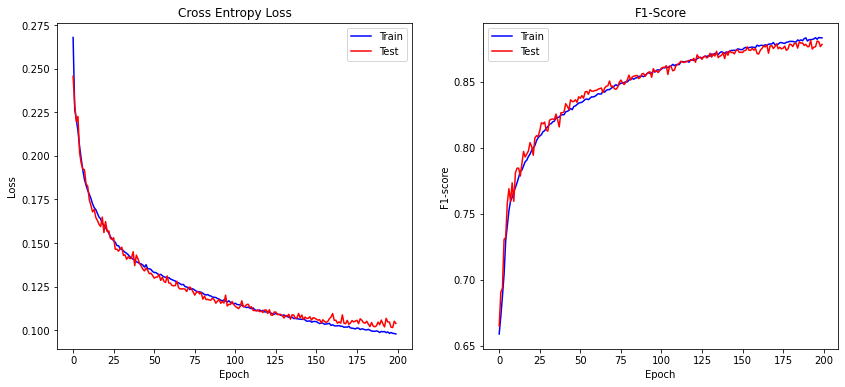

In [24]:
#plot the model performance
plot_utils.plot_model_perf(hist)

* We see from the above graphs that as the training progressed the performance of both the training and validation datasets improved.
* We see a steady decrease in the cross-entropy loss and a steady increase in the F1-score for both the training and validation datasets.
* The model seems to have generalized well to the hold out dataset.

#### Lets load the weights that yielded the best score

In [25]:
%%time
model.load_weights(best_model)

CPU times: user 9.14 ms, sys: 10 ms, total: 19.2 ms
Wall time: 18.4 ms


#### Evaluate and print the score

In [26]:
%%time
score = model.evaluate(X_test, Y_test, verbose=0)
print('Loss:', score[0])
print('F1-score:', score[1])

Loss: 0.10140404850244522
F1-score: 0.8801668882369995
CPU times: user 3min 46s, sys: 2min 3s, total: 5min 49s
Wall time: 45.2 s


The model has a F1-score of 0.88, i.e 88%, and a loss of 0.1<BR>
This is a significant improvement from the F1-score of 81% and loss of 0.15 that we saw earlier.

In the [next notebook](./AmazonForest-visualize-activations.ipynb) we will explore the activation maps generated by the convolutional neural networks.